Recently I had to implement an optimization algorithm to extract
material properties from an experiment. In that problem I was
minimizing the Euclidean norm of the residuals and since it is a convex a
simple gradient descent did the job satisfactory. However, I decided
to teach myself more sophisticated methods for future work when I
might have to minimize harder problems. In this post I will
implement and compare the gradient descent method without momentum
and the Newton conjugate gradient method as implemented in SciPy.

# Gradient descent

The gradient descent method computes the derivative at the current
point to determine the step direction and then given a step size
calculates the next point. It is the simplest optimization algorithm
and given a convex function (local minima is a global minima) and a sufficient step it
will converge satisfactory. Let's implement it! I will use the *numpy*
and the *autograd* package to calculate my derivatives using automatic
differentiation. For *simple* functions we can write our own
analytical solutions, however, I would like to explore more complex
functions so it is good practise to implement it.

In [1]:
import autograd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

Then we need to define a function to explore. Let's go with a simple
convex function to illustrate the idea.

\begin{equation}
f(x) = x^2
\end{equation}

In [2]:
def fun(x):
    return x**2

The gradient descent algorithm in one dimension can be written as written in Equation 2.

\begin{equation}
x_{i+1} = x_i - \alpha \nabla f(x_i)
\end{equation}

Where $\nabla = \frac{df}{dx}$ represents the gradient in one dimension and is also known as the Jacobian in multiple dimensions. The gradient descent algorithm can then be written.

In [3]:
def grad_desc(x, fun, alpha=0.1, max_iter=100):
    xs = np.zeros(1 + max_iter)
    xs[0] = x
    grad = autograd.grad(fun)
    
    for step in range(max_iter):
        x = x - alpha * grad(x)
        xs[step + 1] = x
        
    return xs

Lets explore a solution of our convex function which has a minima at
$(0,0)$. The optimization is performed for a
total to 10 steps and a step size of $\alpha = 0.1$.

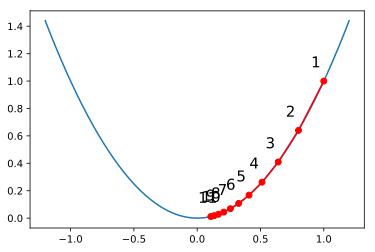

In [4]:
alpha = 0.1
x0 = 1.

x_opt = grad_desc(x0, fun, alpha = alpha, max_iter = 10)
y_opt = fun(x_opt)

x_true = np.linspace(-1.2, 1.2, 100)
y_true = fun(x_true)

plt.plot(x_true, y_true)
plt.plot(x_opt, y_opt, 'o-', c='red')

for i, (x, y) in enumerate(zip(x_opt, y_opt), 1):
      plt.text(x - 0.1, y + 0.1, i, fontsize=15)

plt.show()

From the figure it is clear that when the gradient was large
(i.e. step 1-2) the jump was also large. As the gradient decreases
(i.e. step > 4) the jumps also decrease. This is straightforward from
our formulation. But what would happen if we chose a different step , say $\alpha = 0.7$, as we could if we first attempt to solve a complex problem?

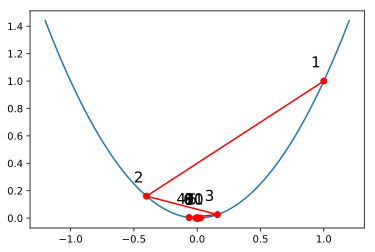

In [5]:
alpha = 0.7
x0 = 1.

x_opt = grad_desc(x0, fun, alpha = alpha, max_iter = 10)
y_opt = fun(x_opt)

plt.plot(x_true, y_true)
plt.plot(x_opt, y_opt, 'o-', c='red')

for i, (x, y) in enumerate(zip(x_opt, y_opt), 1):
      plt.text(x - 0.1, y + 0.1, i, fontsize=15)

plt.show()

Here we can see that the calculation starts to oscillate around the local minima due to the larger step size. It is evident that this is not efficient. Let's move away now from toy examples and see a more useful optimization algorithm.

# Newton conjugate gradient

Let us consider the Himmelblau test function given in Equation 3. It is named after David Mautner Himmelblau (1924-2011) who introduced it in the Applied Nonlinear Programming (1972) textbook.

\begin{equation}
f(x) = (x_1^2 + x_2 - 11)^2 + (x_1 + x_2^2 - 7)^2
\end{equation}

Which we can translate to code.

In [6]:
def himmelblau(p):
    x, y = p
    a = x*x + y - 11
    b = x + y*y - 7
    return a*a + b*b

This function is typically used to test numerical optimization codes. Here we implement the Newton conjugate gradient method to solve it. The pure Newton method is given by solving the $n \times n$ symmetric linear system given in Equation 4. The method needs the first two derivatives of the function: the Jacobian and the Hessian.

\begin{equation}
\nabla^2 f(x_k) p_k^N = -\nabla f(x_k)
\end{equation}

Here $\nabla^2$ is known as the Hessian and $p_k^N$ is the search direction. The problem here is that the Hessian might not always be positive definite and as a result the search direction may not always lead to descent.

In this post I will focus on the implementation in [scipy@54e1727a#L1504](https://github.com/scipy/scipy/blob/54e1727a603f7698957f43ea2cd6236fe2530615/scipy/optimize/optimize.py#L1504) which uses the so called *truncated Netwon method*.

We first compute the search direction $p_k^N$ by applying the Conjugate Gradient method to Equation 4 and try to satisfy the termination criteria in Equation 5.

\begin{equation}
|| r_k \vert \vert \leq \eta_k || \nabla f(x_k) ||
\end{equation}

Where $r_k$ is the residual at step $k$ and $\eta_k$ is chosen to obtain superlinear or quadratic convergence. In SciPy the value is set to obtain superlinear convergence as given in Equation 6.

\begin{equation}
\eta_k = min \left( 0.5, \sqrt{ || \nabla f(x_k) || } \right)
\end{equation}

The curvature also needs to be continuously checked since as mentioned above the Hessian might not be positive definite and the Conjugate Gradient method would not work. In this case Scipy defaults to the steepest descent method.

Finally, the step $\alpha_k$ needs to be chosen in order to update Equation 7 for the current iteration.

\begin{equation}
x_{k+1} = x_k + \alpha_k p_k
\end{equation}

$\alpha_k$ is chosen to satisfy the Wolfe condition using a line search method from the Minpack library. The Wolfe condition itself is given as a requirement that $\alpha_k$ should give a sufficient decrease of the objective function. This is expresed in Equation 8 for a constant $c_1$.

\begin{equation}
f(x_k + \alpha_k p_k) \leq f(x_k) + c_1 \alpha_k \nabla f_k^T p_k
\end{equation}

A further rule to remove very small steps is also used which takes into account the curvature in Equation 9 for a constant $c_2$.

\begin{equation}
\nabla f (x_k + \alpha_k p_k)^T  p_k \geq c_2 \nabla f_k^T p_k
\end{equation}

We can now use the implementation in the SciPy optimize package.

In [7]:
from scipy import optimize

A useful feature of the Newton conjugate gradient method is that it does not explicitly require the Hessian. This means that we can supply only the matrix-vector product of the form given in Equation 10 for a given vector $p$.

\begin{equation}
\nabla^2 f(x_k)p
\end{equation}

This is great news when in a complex problem we cannot provide an analytical Hessian or when the required memory to store it is too big. Here again we use the automatic differentiation for convenience. The Jacobian is implemented here as well.

In [8]:
def himmelblau_grad(p):
    gradiend = autograd.grad(himmelblau)
    return gradiend(p)

Which we can of course check with the analytical gradient.

In [9]:
grad_x = lambda x, y: np.array([4*x**3 + 4*x*y - 42*x + 2*y**2 - 14,
                                2*x**2 + 4*x*y + 4*y**3 - 26*y - 22])
grad_x(1., 1.)

array([-46., -38.])

In [10]:
himmelblau_grad((1., 1.))

(array(-46.), array(-38.))

And of course that it works! Let's do the Hessian as well.

In [11]:
def himmelblau_hess(p):
    hessian = autograd.hessian(himmelblau)
    return hessian(p)

We then define a function to perform the optimization.

In [12]:
def run_himmelblau(himmelblau_x0):
    x0 = np.array(himmelblau_x0)
    sol = optimize.minimize(himmelblau,
                            x0,
                            jac = himmelblau_grad,
                            hess = himmelblau_hess,
                            method = 'Newton-CG',
                            tol=1e-6)
    return sol

To visualize the results we need to interpolate between the calculated points. Matplotlib takes care of that and leaves us the choice of resolution. I have found that a $0.01 \times 0.01$ grid displays well.

In [13]:
# set resolution
dx, dy = 0.01, 0.01

# generate 2d grids
y, x = np.mgrid[slice(-6, 6 + dy, dy),
                slice(-6, 6 + dx, dx)]

Here I switch from svg to png to make the visualization easier and I also plot the analytical solutions.

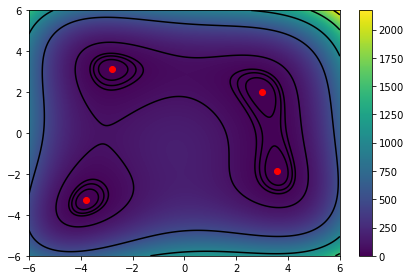

In [14]:
set_matplotlib_formats('png')
z = himmelblau((x, y))
plt.pcolormesh(x, y, z)
plt.colorbar()
plt.contour(x, y, z, [0., 10., 20., 30., 100., 500., 1000., 1500., 2000.], colors='k')
plt.scatter([3.0, -2.805118, -3.779310, 3.584428], [2.0, 3.131312, -3.283186, -1.848126], color = 'r')
plt.tight_layout()
plt.show()

Great we can see the minimas marked in red. We can now run the optimization and try to see if we can find them. The algorithm will find the closest minima to our starting point. For this we can chose the bottom right first.

In [15]:
himmelblau_x0 = [2., -4]
test_run = run_himmelblau(himmelblau_x0)
test_run

/home/nik/Envs/ds/local/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


     fun: 8.204153414298523e-29
     jac: array([ 1.48236741e-07, -1.53300283e-06])
 message: 'Optimization terminated successfully.'
    nfev: 11
    nhev: 9
     nit: 9
    njev: 19
  status: 0
 success: True
       x: array([ 3.58442834, -1.84812653])

We seem to have found a minima! Let's plot it and see the route we took. The blue dot will show the start location and the red will show the final location.

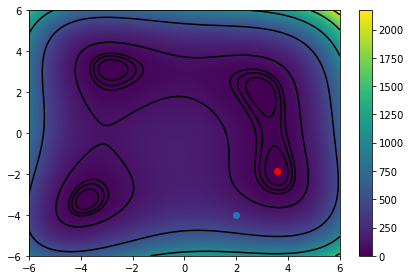

In [16]:
plt.pcolormesh(x, y, z)
plt.colorbar()
plt.contour(x, y, z, [0., 10., 20., 30., 100., 500., 1000., 1500., 2000.], colors='k')
plt.scatter(test_run.x[0], test_run.x[1], color = 'r')
plt.scatter(himmelblau_x0[0], himmelblau_x0[1])
plt.tight_layout()
plt.show()

An interesting trip! : )